The purpose of this note book is to demonstrate how teh profit optimisation model works.

The code bellow imports all relevant python packages

In [1]:
import sys
sys.path.append('../')

from src.cumulative_Weibull_distribution_model import cumulative_weibull_distribution_from_conductance_loss_at_given_water_potentials
from src.hydraulic_cost_model import HydraulicCostModel
from src.leaf_air_coupling_model import LeafAirCouplingModel
from src.photosynthesis_model import PhotosynthesisModel
from src.CO2_gain_model import CO2GainModel
from src.profit_optimisation_model import ProfitOptimisationModel

from src.conversions import degrees_centigrade_to_kelvin

from numpy import linspace, zeros
from numpy import argmax
from matplotlib import pyplot as plt

# The Model

The core principle of the model is that the plant acts to maximise its photosynthesis rate while minimising the damage to xylem due to water stress. This principle is modeld using a profit maximisation approach. The profit of the system is defiend as the net gain in carbon $CG(\psi_{leaf})$ minus the hydraulic cost $HC(\psi_{leaf})$. The leaf adjusting the stomata to achive the leaf water potential $\psi_{leaf}$ that maximises the profit.


$$ \text{Profit}_{\text{max}} = \text{max}(CG(\psi_{leaf}) - HC(\psi_{leaf})) $$

# Hydraulic cost

The hydraulic cost of the plan reflects the increased potential for xylem damage due to a loss of hydraulic conductance:

$$ HC(\psi_{leaf}) = \frac{k_{i,max} - k(\psi_{leaf})}{k_{i,max} - k_{crit}} $$

Here $k(\psi)$ is the hydraulic conductance at a given water potential, $k_{i,max}$ is the maximum potential conductance at a given instance in time (i.e the conductance evaluated at the soil water potential) and $k_{crit}$ is the conductance that induses xylem failure.

## Hydraulic conductance

Before we can calculate the hydraulic cost it is necessary to create a model of hydraulic conductance, this is achived by using a cummulative Weibull distribution,

$$ k(\psi) = k_{max}e^{-(\psi/b)^c} $$

Here $k_{max}$ is the maximum possible conductance at a water potential of zero, $b$ is the sensetivity of the funcion to changes in water ptotential and $c$ is some shape paramiter. The values of $k_{max}$, $b$ and $c$ are dependent on the tree being modeled. Specificaly the values of $b$ and $c$ are calcuated based on the water potentials coresponding to two fractional losses of conductance ($k(\psi)/k_{max}$). For example Juniperus virginiana suffers a conductance loss of $50\%$ at $-6.6MPa$ and $88\%$ at $-10.5MPa$.

The code bellow plots the hdraulic conductance as a function of water potential.

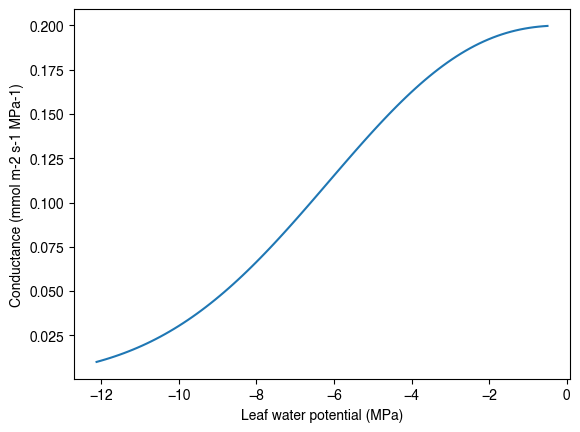

In [2]:
# Conductance model
P50 = - 6.6 # MPa
P88 = -10.5 # MPa
k_max = 0.2 # mmol m-2 s-1 MPa-1

conductance_model = cumulative_weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max,
                                                                                                    P50,
                                                                                                    P88,
                                                                                                    0.5,
                                                                                                    0.88)

# Water potential range
soil_water_potential = -0.5 # MPa
critical_water_potential = conductance_model.water_potential_from_conductivity_loss_fraction(0.95) # MPa
water_potentials = linspace(soil_water_potential, critical_water_potential, 100)

# Conductances
conductances = conductance_model.conductance(water_potentials)

# Ploting
plt.plot(water_potentials, conductances)
plt.xlabel("Leaf water potential (MPa)")
plt.ylabel("Conductance (mmol m-2 s-1 MPa-1)")
plt.show()

Having modeled the trees hydraulic conductance we can now use this to calcualte the hydraulic cost as a function of leaf water potential.

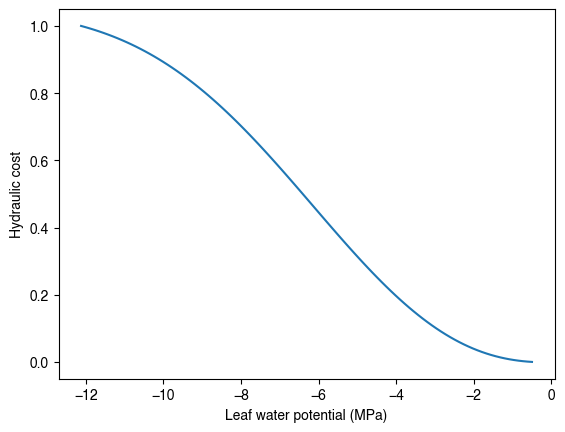

In [3]:
hydraulic_cost_model = HydraulicCostModel(conductance_model, soil_water_potential, critical_water_potential)

hydraulic_costs = hydraulic_cost_model.hydraulic_cost_as_a_function_of_leaf_water_potential(water_potentials, 
                                                                                            soil_water_potential)

# Plotting
plt.plot(water_potentials, hydraulic_costs)
plt.xlabel("Leaf water potential (MPa)")
plt.ylabel("Hydraulic cost")
plt.show()

# Transpiration

Assuming that the tree exists in a steady state, the rate of flow of water from the soil to the leaf is equal to that from the leaf to the air through transpiration. The rate of flow from the soil to the leaf is given by the integral,

$$ E(\psi_{leaf}) = \int_{\psi_{soil}}^{\psi_{leaf}} k(\psi) d\psi $$

The code bellow plots transpiration as a function of leaf water potential

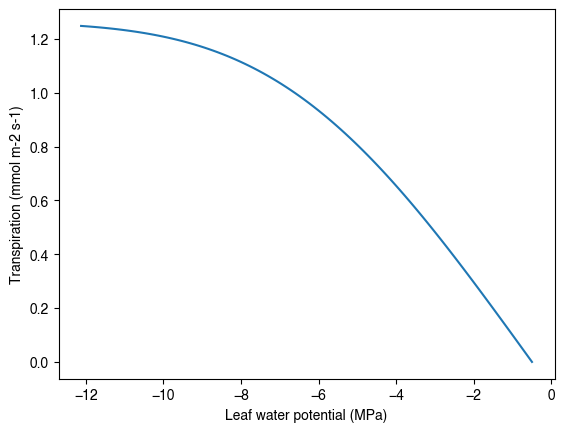

In [4]:
transpiration_values = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    transpiration_values[i] = hydraulic_cost_model.transpiration(water_potentials[i], soil_water_potential)

plt.plot(water_potentials, transpiration_values)
plt.xlabel("Leaf water potential (MPa)")
plt.ylabel("Transpiration (mmol m-2 s-1)")
plt.show()

## Stomatal conductance

The equation for transpiration from the leaf via the sromata is

$$ E = \frac{e_{sat}(T_{leaf}) - e_{air}}{P_{air}} g_{lw} $$

where $e_{sat}(T_{leaf})$ is the vapour pressure of the air within the stomata (this air having the same temperature as the leaf), $e_{air}$ is the vapour pressure of the air, $P_{air}$ is the air pressure and $g_{lw}$ is the conductance to water between the leaf and the atmostphere.

We make two simlifying asumptions to this equation. First we asume perfect leaf atmostphere coupling such that the only restriction to the flow of water from the leaf to the air is the stomatal conductance meaning that $g_{lw} \rightarrow g_{sw}$. The second asumption is that the temperature of the leaf is equal to that of the air. This means that the vapour pressure within the stomata is equal to the saturatd vapour pressure of the air, $e_{sat}(T_{air})$. In masking this substitution the difference in vapour pressure is now equal to the vapour pressure deficit $\text{VPD} = e_{sat}(T_{air}) - e_{air}$.

Given this we can use the transpiration rate calculated previously along with measurments of air pressure and vapour pressure deficit to get the stomatal conductance to water. It is then trivial to convert to the stomatal conductance to carbon by multiplying by their ration ($1.57$)

The stomatal conductance to water and carbon as a function of leaf water potential is plotted below.

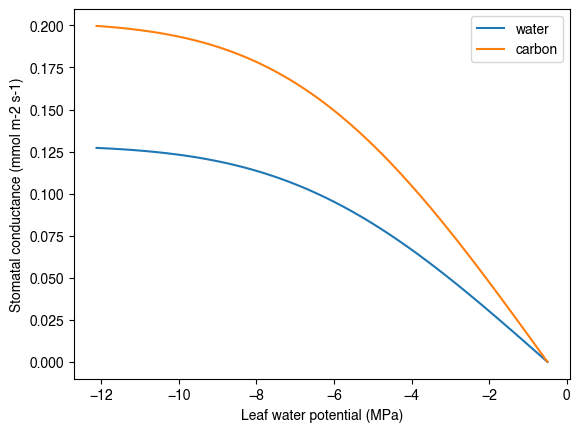

In [5]:
air_temperature = degrees_centigrade_to_kelvin(25.)
air_vapour_pressure_deficit = 1 # kPa
air_pressure = 101.9 # kPa

leaf_air_coupling_model = LeafAirCouplingModel()
stomatal_conductances_to_water = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    stomatal_conductances_to_water[i] = leaf_air_coupling_model.stomatal_conductance_to_water(transpiration_values[i],
                                                                                              air_temperature,
                                                                                              air_vapour_pressure_deficit,
                                                                                              air_pressure)

# We want stomatal conductance in mol m-2 s-1 (currently mmol m-2 s-1)
stomatal_conductances_to_water /= 1000
    
stomatal_conductances_to_carbon = 1.57 * stomatal_conductances_to_water

plt.plot(water_potentials, stomatal_conductances_to_water, label = "water")
plt.plot(water_potentials, stomatal_conductances_to_carbon, label = "carbon")
plt.legend()
plt.xlabel("Leaf water potential (MPa)")
plt.ylabel("Stomatal conductance (mmol m-2 s-1)")
plt.show()

# Net carbon gain

By assuming that the system is in a steady state the net flow of carbon from the atmostphere into the leaf via the stomata is equal to the net uptake of carbon due to photosynthesis.

$$ A_n(c_i) = (c_a - c_i)g_{lc} $$

where $c_a$ and $c_i$ are the atmospheric and intercelular carbon consentrations respectivly and $g_{lc}$ is the leaf conductance to carbon calculated above. The problem with calculating $A_n$ directly from this equation is that we don't have measurment of $c_i$.

The net carbon uptake can alternativly be calculated from the $CO_2$ uptake during carboxylation $V_c$, $CO_2$ loss during oxygentation $V_o$ and $CO_2$ loss from mitochondrial respiration $R_d$.

$$ A_n(c_i) = V_c(c_i) - 0.5V_o(c_i) - R_d $$

This can be simplified by substituting in the $CO_2$ compensation point $\Gamma^*$ such that,

$$ A_n(c_i) = (1 - \frac{\Gamma^*}{c_i})V_c(c_i) - R_d $$

For simplicity we will asume that the net $CO_2$ uptake is describd wholy by the Rubisco-limited craboxylation rate,

$$ V_c(c_i) = \frac{V_{c \text{max}}c_i}{c_i + K} $$

where $K$ is the michaelis menten constant of carboxylation. Given this we have a second equation for carbon uptake as a funcion of intercellular $CO_2$.

$$ A_n(c_i) = (1 - \frac{\Gamma^*}{c_i})\frac{V_{c \text{max}}c_i}{c_i + K} - R_d $$

Combining the two equations for carbon uptake gives,

$$ (c_a - c_i)g_{lc} = (1 - \frac{\Gamma^*}{c_i})\frac{V_{c \text{max}}c_i}{c_i + K} - R_d $$

Rearanging this equation to solve for $c_i$ results in the following quadratic equation,

$$ -g_{lc} c_i^2 + ((c_a - k) g_{lc} + R_d - V_cmax) c_i + ((c_a g_{lc} + R_d)k + \Gamma^* V_{c \text{max}}) = 0 $$

The first step to calculating the net carbon uptake is hence to solve this quadratic for $c_i$. The code bellow solves for $c_i$ and plots the results as a function of water leaf potential.

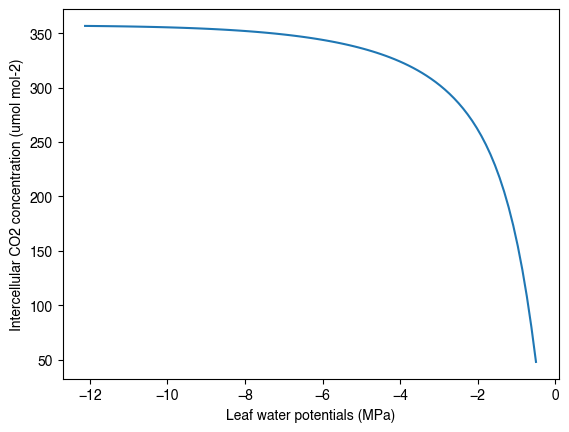

In [6]:
atmospheric_CO2_concentration = 400. # (umol mol-1)
intercellular_oxygen = 210.0 #(umol mol-1)

photosynthesis_model = PhotosynthesisModel()

intercellular_CO2_concentrations = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    intercellular_CO2_concentrations[i] = \
        photosynthesis_model.intercellular_CO2_concentration(stomatal_conductances_to_carbon[i],
                                                             atmospheric_CO2_concentration,
                                                             air_temperature,
                                                             intercellular_oxygen)

plt.plot(water_potentials, intercellular_CO2_concentrations)
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Intercellular CO2 concentration (umol mol-2)")
plt.show()

Given a value for the intercellular $CO_2$ concentration, the net $CO_2$ asimilation rate can be caclulated using the difusion equation for $CO_2$ passing through the stomata,

$$ A_n = (c_a - c_i)g_{sc} $$

The code bellow plots this as a function of leaf water potential.

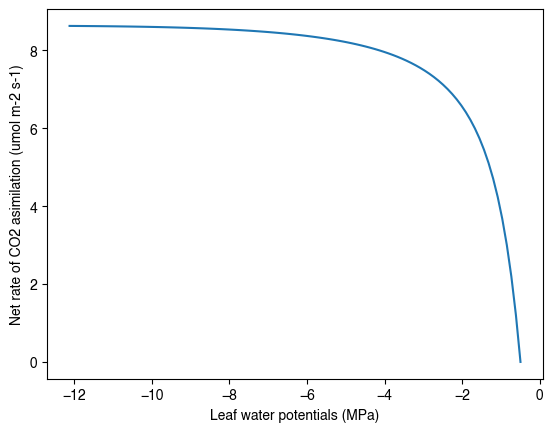

In [7]:
net_CO2_asimilation = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    net_CO2_asimilation[i] = \
        photosynthesis_model.net_rate_of_CO2_assimilation(stomatal_conductances_to_carbon[i],
                                                          atmospheric_CO2_concentration,
                                                          air_temperature,
                                                          intercellular_oxygen)

plt.plot(water_potentials, net_CO2_asimilation)
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Net rate of CO2 asimilation (umol m-2 s-1)")
plt.show()

To make use of the net $CO_2$ gain as a funtion of leaf water potential within the profit maximisation model we normalise the function by dividing by its maximum value over the range $[\psi_s, \psi_{crit}]$.

$$ \text{CG} = \frac{A_n(\psi_{leaf})}{\text{max}(A_n(\psi_{leaf}))} $$

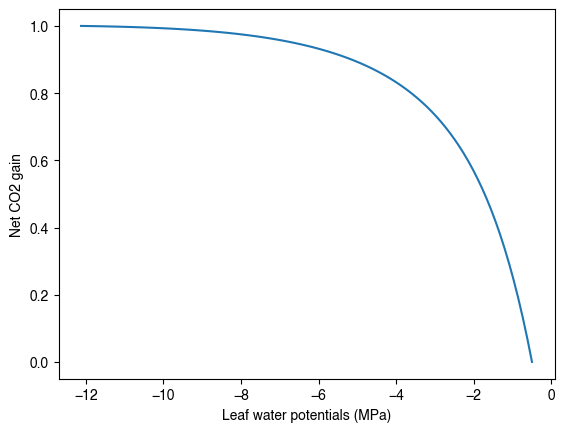

In [8]:
CO2_gain_model = CO2GainModel(leaf_air_coupling_model,
                              photosynthesis_model)

carbon_gain, max_CO2_uptake = CO2_gain_model.CO2_gain(transpiration_values,
                                                      air_temperature,
                                                      air_vapour_pressure_deficit,
                                                      air_pressure,
                                                      atmospheric_CO2_concentration,
                                                      intercellular_oxygen)

plt.plot(water_potentials, carbon_gain)
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Net CO2 gain")
plt.show()

# Profit

Now that we have both the carbon gain and hydraulic cost for the system as a function of leaf water potential we can calculate the proffit as a function of leaf water potential,

$$ \text{Profit}(\psi_{leaf}) = \text{CG}(\psi_{leaf}) - \text{HC}(\psi_{leaf}) $$

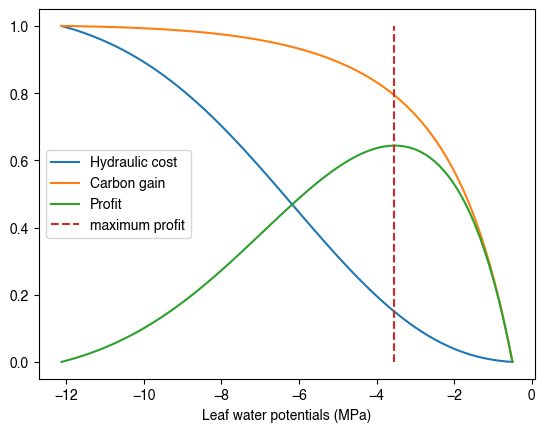

In [9]:
profit_optimisation_model = ProfitOptimisationModel(hydraulic_cost_model, leaf_air_coupling_model, CO2_gain_model)

profit_values, carbon_gain, hydraulic_costs, __, __ = \
    profit_optimisation_model.profit_as_a_function_of_leaf_water_potential(water_potentials,
                                                                           soil_water_potential,
                                                                           air_temperature,
                                                                           air_vapour_pressure_deficit,
                                                                           air_pressure,
                                                                           atmospheric_CO2_concentration,
                                                                           intercellular_oxygen)

maximum_profit_id = argmax(profit_values)
optimal_leaf_water_potential = water_potentials[maximum_profit_id]

plt.plot(water_potentials, hydraulic_costs, label = "Hydraulic cost")
plt.plot(water_potentials, carbon_gain, label = "Carbon gain")
plt.plot(water_potentials, profit_values, label = "Profit")
plt.plot([optimal_leaf_water_potential, optimal_leaf_water_potential], [0,1], linestyle='--', label = "maximum profit")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

# Varying environmental condictions

Now we have a model for calulating the optimal leaf water potential ($\psi_{leaf\_opt}$) along with corresponding net $CO_2$ uptake ($A_{n\_opt}$) and transpiration rate ($E_{opt}$), we can investigate how changing the environmental conditions affects these values.

## Soil water potential

First lets vary the soil water potential

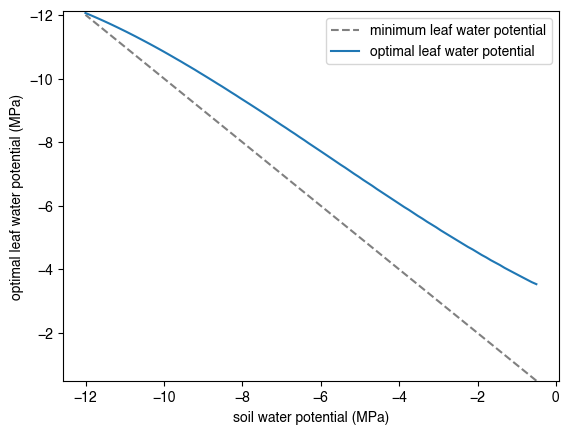

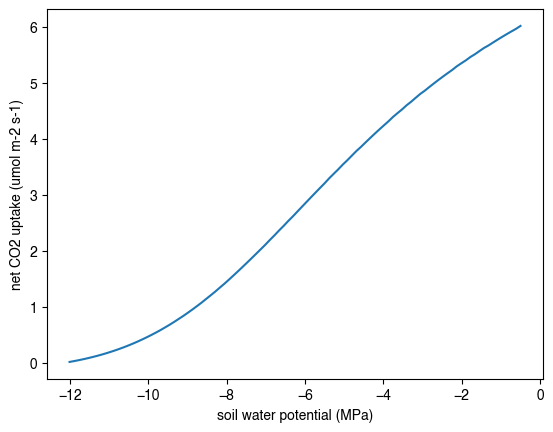

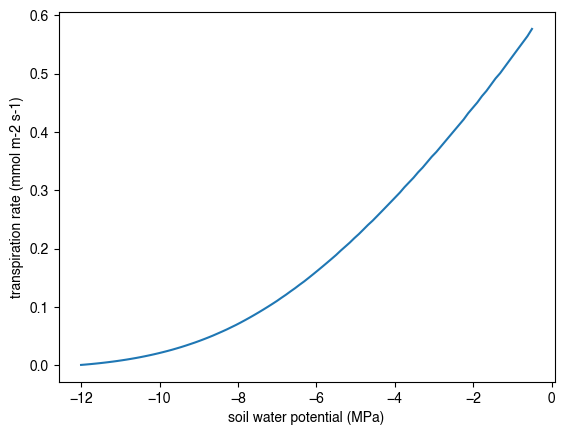

In [18]:
minimum_soil_water_potential = -0.5 # MPa
maximum_soil_water_potential = critical_water_potential # MPa

soil_water_potentials = linspace(minimum_soil_water_potential,
                                 maximum_soil_water_potential,
                                 num = 100,
                                 endpoint = False) # MPa

optimal_leaf_water_potentials = zeros(len(soil_water_potentials))
net_CO2_uptake_values = zeros(len(soil_water_potentials))
transpiration_rates = zeros(len(soil_water_potentials))

for i in range(len(soil_water_potentials)):
    optimal_leaf_water_potentials[i], net_CO2_uptake_values[i], transpiration_rates[i] = \
        profit_optimisation_model.optimal_state(soil_water_potentials[i],
                                                air_temperature,
                                                air_vapour_pressure_deficit,
                                                air_pressure,
                                                atmospheric_CO2_concentration,
                                                intercellular_oxygen)

plt.plot(soil_water_potentials, soil_water_potentials,
         linestyle = "--", label = "minimum leaf water potential", c = "grey")
plt.plot(soil_water_potentials, optimal_leaf_water_potentials,
         label = "optimal leaf water potential")

# Leaf water potential
plt.legend()
plt.xlabel("soil water potential (MPa)")
plt.ylabel("optimal leaf water potential (MPa)")
plt.ylim(minimum_soil_water_potential, critical_water_potential)
plt.show()

# net CO2 uptake
plt.plot(soil_water_potentials, net_CO2_uptake_values)
plt.xlabel("soil water potential (MPa)")
plt.ylabel("net CO2 uptake (umol m-2 s-1)")
plt.show()

# transpiration rate
plt.plot(soil_water_potentials, transpiration_rates)
plt.xlabel("soil water potential (MPa)")
plt.ylabel("transpiration rate (mmol m-2 s-1)")
plt.show()